In [1]:
# !pip install torch torchvision wandb --q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.4 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have 

In [5]:
import numpy as np
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:

wandb.login(key='f0880f1a8675dc5a9ff218689c5340669690b6e0')


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ed24s401 (ed24s401-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [7]:

!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip
!unzip nature_12K.zip

--2025-04-19 15:01:08--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.64.207, 74.125.201.207, 74.125.132.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.64.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip’

nature_12K.zip      100%[===================>]   3.55G   267MB/s    in 14s     

2025-04-19 15:01:22 (262 MB/s) - ‘nature_12K.zip’ saved [3816687935/3816687935]

Archive:  nature_12K.zip
   creating: inaturalist_12K/
  inflating: inaturalist_12K/.DS_Store  
   creating: inaturalist_12K/train/
   creating: inaturalist_12K/train/Plantae/
  inflating: inaturalist_12K/train/Plantae/1dfc3916ad58af6ce9af9fc8b36ceedd.jpg  
  inflating: inaturalist_12K/train/Plantae/e49eeff2b27ae74351fdf8ffa3791307.jpg  
  inflating: inaturalist_12K/train/Plantae/519ae1c558dff337bb4084934e31a4a8.jpg  
 

In [8]:
import os
os.listdir('/kaggle/working/inaturalist_12K/train')

['Fungi',
 'Insecta',
 'Mollusca',
 'Reptilia',
 'Amphibia',
 'Animalia',
 'Mammalia',
 '.DS_Store',
 'Plantae',
 'Arachnida',
 'Aves']

In [9]:
import torch
import torch.nn as nn

# ——— reuse the SAME model class as in Q2 ———
ACTIVATIONS = {"ReLU":nn.ReLU, "GELU":nn.GELU, "SiLU":nn.SiLU, "Mish":nn.Mish}

class SmallCNN(nn.Module):
    def __init__(self,
                 in_ch:int = 3,
                 filters_per_layer:list[int] = None,
                 kernel_size:int = 3,
                 activation:str = "ReLU",
                 dense_units:int = 128,
                 num_classes:int = 10,
                 input_size:int = 128):
        super().__init__()
        if filters_per_layer is None:
            filters_per_layer = [32]*5
        act = ACTIVATIONS[activation]
        layers = []
        c = in_ch
        for f in filters_per_layer:
            layers += [
                nn.Conv2d(c, f, kernel_size, padding=kernel_size//2),
                act(inplace=True),
                nn.MaxPool2d(2)
            ]
            c = f
        self.features = nn.Sequential(*layers)

        # compute flattened feature‐size
        final_spatial = input_size // (2**len(filters_per_layer))
        flat_dim = c * final_spatial * final_spatial
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, dense_units),
            act(inplace=True),
            nn.Linear(dense_units, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# ——— analytic counters for any filters_per_layer, k, n ———
def total_macs(filters_per_layer: list[int],
               kernel_size: int,
               dense_units: int,
               num_classes: int = 10) -> int:
    """
    Total MACs per forward pass, IGNORING spatial map sizes.
    """
    in_ch = 3
    # conv layers: sum over blocks i=0..4 of (in_ch_i * out_ch_i * k^2)
    macs = 0
    prev = in_ch
    for out_ch in filters_per_layer:
        macs += prev * out_ch * (kernel_size**2)
        prev = out_ch

    # dense head: last_feature_channels * dense_units + dense_units * num_classes
    macs += filters_per_layer[-1] * dense_units
    macs += dense_units * num_classes
    return macs

def total_params(filters_per_layer: list[int],
                 kernel_size: int,
                 dense_units: int,
                 num_classes: int = 10) -> int:
    """
    Total trainable parameters (weights + biases).
    """
    in_ch = 3
    params = 0
    prev = in_ch
    # conv blocks
    for out_ch in filters_per_layer:
        # weights + biases
        params += prev * out_ch * (kernel_size**2)  # conv weights
        params += out_ch                            # conv biases
        prev = out_ch

    # dense layer weights + biases
    params += filters_per_layer[-1] * dense_units
    params += dense_units

    # output layer weights + biases
    params += dense_units * num_classes
    params += num_classes

    return params

# ——— example usage ———
if __name__ == "__main__":
    # pick exactly the same sweep-able choices as in Q2:
    filters_per_layer = [32]*5   # or [16,32,64,128,256], etc.
    k = 3
    n = 128
    num_cls = 10

    print("Model structure:")
    model = SmallCNN(filters_per_layer=filters_per_layer,
                     kernel_size=k,
                     activation="ReLU",
                     dense_units=n,
                     num_classes=num_cls,
                     input_size=128)
    print(model)

    macs   = total_macs(filters_per_layer, k, n, num_cls)
    params = total_params(filters_per_layer, k, n, num_cls)
    print(f"\nTotal MACs   = {macs:,}")
    print(f"Total Params = {params:,}")


Model structure:
SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (c

In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1) Point at your iNaturalist subset
DATA_DIR = "/kaggle/working/inaturalist_12K/train"

# 2) Quick transform to just load & tensor‑ify
tmp_tf = transforms.Compose([
    transforms.Resize((224,224)),   # or whatever resize you’ll use
    transforms.ToTensor()
])
ds = datasets.ImageFolder(DATA_DIR, transform=tmp_tf)
loader = DataLoader(ds, batch_size=8, shuffle=True)

# 3) Grab one batch to inspect its shape
imgs, labels = next(iter(loader))
print("Batch shape:", imgs.shape)  
# e.g. torch.Size([8, 3, 128, 128])

# 4) Instantiate exactly the same SmallCNN from Q1/Q2
model = SmallCNN(
    in_ch=imgs.shape[1],
    filters_per_layer=[32]*5,
    kernel_size=3,
    activation="ReLU",
    dense_units=128,
    num_classes=10,
    input_size=imgs.shape[2]   # height==width==128
)

# 5) Run a forward pass to confirm nothing breaks
out = model(imgs)
print("Output shape:", out.shape)  # torch.Size([8, 10])

# 6) And you can still call your analytic counters
macs   = total_macs([32]*5, 3, 128, num_classes=10)
params = total_params([32]*5, 3, 128, num_classes=10)
print(f"MACs   = {macs:,}")
print(f"Params = {params:,}")


Batch shape: torch.Size([8, 3, 224, 224])
Output shape: torch.Size([8, 10])
MACs   = 43,104
Params = 43,402


## PART A
### ANSWER 1

In [11]:
# Cell 1: MODEL DEFINITION & INSTANTIATION

import torch
import torch.nn as nn

ACTIVATIONS = {"ReLU":nn.ReLU, "GELU":nn.GELU, "SiLU":nn.SiLU, "Mish":nn.Mish}

class SmallCNN(nn.Module):
    def __init__(self,
                 in_ch:int = 3,
                 filters_per_layer:list[int] = None,
                 kernel_size:int = 3,
                 activation:str = "ReLU",
                 dense_units:int = 128,
                 num_classes:int = 10,
                 input_size:int = 128):
        super().__init__()
        if filters_per_layer is None:
            filters_per_layer = [32]*5
        act = ACTIVATIONS[activation]
        layers, c = [], in_ch
        for f in filters_per_layer:
            layers += [
                nn.Conv2d(c, f, kernel_size, padding=kernel_size//2),
                act(inplace=True),
                nn.MaxPool2d(2)
            ]
            c = f
        self.features = nn.Sequential(*layers)

        final_spatial = input_size // (2**len(filters_per_layer))
        flat_dim = c * final_spatial * final_spatial
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, dense_units),
            act(inplace=True),
            nn.Linear(dense_units, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))


# pick your hyper‑params
filters_per_layer = [32]*5
k = 3
n = 128
num_cls = 10

model = SmallCNN(
    filters_per_layer=filters_per_layer,
    kernel_size=k,
    activation="ReLU",
    dense_units=n,
    num_classes=num_cls,
    input_size=128
)
print(model)


SmallCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Seque

In [19]:
# Cell 2: MACs & PARAMS CALCULATION

def total_macs(filters_per_layer: list[int],
               kernel_size: int,
               dense_units: int,
               num_classes: int = 10) -> int:
    macs, prev = 0, 3
    for out_ch in filters_per_layer:
        macs += prev * out_ch * (kernel_size**2)
        prev = out_ch
    macs += filters_per_layer[-1] * dense_units
    macs += dense_units * num_classes
    return macs

def total_params(filters_per_layer: list[int],
                 kernel_size: int,
                 dense_units: int,
                 num_classes: int = 10) -> int:
    params, prev = 0, 3
    for out_ch in filters_per_layer:
        params += prev * out_ch * (kernel_size**2)  # weights
        params += out_ch                            # biases
        prev = out_ch
    params += filters_per_layer[-1] * dense_units
    params += dense_units
    params += dense_units * num_classes
    params += num_classes
    return params

macs   = total_macs(filters_per_layer, k, n, num_cls)
params = total_params(filters_per_layer, k, n, num_cls)

print(f"Total MACs   = {macs:,}")
print(f"Total Params = {params:,}")


Total MACs   = 43,104
Total Params = 43,402


### ANSWER 2

In [12]:
# ─── Cell 1: Imports & Stratified Split ─────────────────────────────────────

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
import wandb

# Constants
DATA_DIR    = "/kaggle/working/inaturalist_12K/train"
IMG_SIZE    = 128
TEST_SIZE   = 0.2
RANDOM_SEED = 42
NUM_CLASSES = 10

# 1. Load dataset just to extract labels
tmp_ds = datasets.ImageFolder(
    DATA_DIR,
    transform=transforms.Resize((IMG_SIZE, IMG_SIZE))
)
labels = np.array(tmp_ds.targets)

# 2. Stratified 80/20 split
sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED
)
train_idx, val_idx = next(sss.split(np.arange(len(labels)), labels))


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", device)

Running on cuda


In [14]:
# ─── Cell 2: Model Definition & Train/Val Loops ─────────────────────────────

# Re‑use EXACT SAME model as Q1
ACTIVATIONS = {
    "ReLU": nn.ReLU,
    "GELU": nn.GELU,
    "SiLU": nn.SiLU,
    "Mish": nn.Mish,
}

class SmallCNN(nn.Module):
    def __init__(self,
                 in_ch: int = 3,
                 filters_per_layer: list[int] = None,
                 kernel_size: int = 3,
                 activation: str = "ReLU",
                 use_batchnorm: bool = False,
                 dropout_p: float = 0.0,
                 dense_units: int = 128,
                 num_classes: int = NUM_CLASSES,
                 input_size: int = IMG_SIZE):
        super().__init__()
        if filters_per_layer is None:
            filters_per_layer = [32]*5
        act_cls = ACTIVATIONS[activation]
        # only ReLU takes inplace=True
        act_kwargs = {"inplace": True} if activation == "ReLU" else {}

        layers, c = [], in_ch
        for f in filters_per_layer:
            layers += [
                nn.Conv2d(c, f, kernel_size, padding=kernel_size//2),
                act_cls(**act_kwargs),      # now safe for all activations
                nn.MaxPool2d(2),
                nn.Dropout2d(dropout_p) if dropout_p>0 else nn.Identity()
            ]
            c = f
        self.features = nn.Sequential(*layers)

        final_spatial = input_size // (2**len(filters_per_layer))
        flat_dim = c * final_spatial * final_spatial
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, dense_units),
            act_cls(**act_kwargs),      # again, no inplace for GELU/Mish/etc.
            nn.Linear(dense_units, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))


def train_one_epoch(model, loader, opt, device):
    model.train()
    total_loss = total_acc = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = F.cross_entropy(preds, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item() * xb.size(0)
        total_acc  += (preds.argmax(1) == yb).sum().item()
    n = len(loader.dataset)
    return total_loss/n, total_acc/n

def validate(model, loader, device):
    model.eval()
    total_loss = total_acc = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = F.cross_entropy(preds, yb)
            total_loss += loss.item() * xb.size(0)
            total_acc  += (preds.argmax(1) == yb).sum().item()
    n = len(loader.dataset)
    return total_loss/n, total_acc/n


##### calculating mean and std

In [15]:
BASE_DIR  = "/kaggle/working/inaturalist_12K"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR  = os.path.join(BASE_DIR, "test")

In [16]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

# 1) Create a loader *without* any normalization
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),          # yields floats in [0,1]
])
train_ds = Subset(
    datasets.ImageFolder(os.path.join(TRAIN_DIR), transform=train_tf),
    train_idx
)
loader = DataLoader(train_ds, batch_size=64, shuffle=False, num_workers=2)

# 2) Accumulate sums and squared‐sums
n_channels = 3
sum_   = torch.zeros(n_channels)
sum_sq = torch.zeros(n_channels)
n_pixels = 0

for imgs, _ in loader:
    # imgs shape: (B, C, H, W)
    B, C, H, W = imgs.shape
    n_pixels += B * H * W

    # sum over batch & spatial dims → shape (C,)
    sum_   += imgs.sum(dim=[0,2,3])
    sum_sq += (imgs**2).sum(dim=[0,2,3])

# 3) Compute mean and std
mean = sum_   / n_pixels
var  = (sum_sq / n_pixels) - mean**2
std  = torch.sqrt(var)

print("Dataset mean:", mean.tolist())
print("Dataset std: ", std.tolist())


Dataset mean: [0.47248995304107666, 0.4606839120388031, 0.3904046416282654]
Dataset std:  [0.23599521815776825, 0.22512102127075195, 0.23602496087551117]


In [19]:
dataset_mean = mean.tolist()
dataset_std = std.tolist()

In [59]:
    # ─── Cell 3: Sweep Function, Transforms & Config ────────────────────────────
    
    def sweep_train():
        run = wandb.init()
        cfg = run.config
    
        # 1) Normalization stats (ImageNet)
        normalize = transforms.Normalize(
            # mean=[0.485, 0.456, 0.406],
            # std= [0.229, 0.224, 0.225]
            mean = dataset_mean,
            std = dataset_std
        )
    
        # 2) Transforms with optional augmentation
        # train_tf = transforms.Compose([
        #     transforms.Resize((IMG_SIZE, IMG_SIZE)),
        #     transforms.RandomHorizontalFlip() if cfg.augmentation else transforms.Identity(),
        #     transforms.ToTensor(),
        #     normalize,
        # ])
        # val_tf = transforms.Compose([
        #     transforms.Resize((IMG_SIZE, IMG_SIZE)),
        #     transforms.ToTensor(),
        #     normalize,
        # ])
        train_tf_list = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        ]
        if cfg.augmentation:
            train_tf_list.append(transforms.RandomHorizontalFlip())
        train_tf_list += [
            transforms.ToTensor(),
            normalize,
        ]
        train_tf = transforms.Compose(train_tf_list)
    
        val_tf = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            normalize,
        ])
    
        # 3) DataLoaders per-run
        train_ds = Subset(
            datasets.ImageFolder(DATA_DIR, transform=train_tf),
            train_idx
        )
        val_ds = Subset(
            datasets.ImageFolder(DATA_DIR, transform=val_tf),
            val_idx
        )
        train_loader = DataLoader(train_ds,
                                  batch_size=cfg.batch_size,
                                  shuffle=True,  num_workers=2)
        val_loader   = DataLoader(val_ds,
                                  batch_size=cfg.batch_size,
                                  shuffle=False, num_workers=2)
    
        # 4) Build filter schedule
        base = cfg.filters
        if cfg.filter_organ == "constant":
            filt_list = [base]*5
        elif cfg.filter_organ == "double":
            filt_list = [base*(2**i) for i in range(5)]
        else:  # "half"
            filt_list = [max(1, base//(2**i)) for i in range(5)]
    
        # 5) Instantiate model
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = SmallCNN(
            in_ch             = 3,
            filters_per_layer = filt_list,
            kernel_size       = cfg.kernel_size,
            activation        = cfg.activation,
            use_batchnorm     = cfg.batchnorm,
            dropout_p         = cfg.dropout,
            dense_units       = cfg.hidden_units,
            num_classes       = NUM_CLASSES,
            input_size        = IMG_SIZE
        ).to(device)
    
        opt = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate)
    
        # 6) Training loop
        for epoch in range(cfg.epochs):
            tr_loss, tr_acc = train_one_epoch(model, train_loader, opt, device)
            val_loss, val_acc = validate(model, val_loader, device)
            wandb.log({
                "epoch":      epoch,
                "train_loss": tr_loss,
                "train_acc":  tr_acc,
                "val_loss":   val_loss,
                "val_acc":    val_acc
            })
    
    
    # 7) Sweep configuration
    sweep_config = {
        "method": "random",
        "metric": {"name": "val_acc", "goal": "maximize"},
        "parameters": {
            "filters":       {"values": [16, 32, 64]},
            "filter_organ":  {"values": ["constant", "double", "half"]},
            "kernel_size":   {"values": [3, 5]},
            "activation":    {"values": list(ACTIVATIONS.keys())},
            "augmentation":  {"values": [False, True]},
            "batchnorm":     {"values": [False, True]},
            "dropout":       {"values": [0.0, 0.2, 0.3]},
            "hidden_units":  {"values": [64, 128, 256]},
            "learning_rate": {"values": [1e-3, 5e-4, 1e-4]},
            "batch_size":    {"values": [32, 64]},
            "epochs":        {"value": 10}
        }
    }
    
    # 8) Launch the sweep 
    sweep_id = wandb.sweep(sweep_config, project="assignment_2_sweep")
    wandb.agent(sweep_id, function=sweep_train, count=30)


Create sweep with ID: lug26qmn
Sweep URL: https://wandb.ai/ed24s401-indian-institute-of-technology-madras/assignment_2_sweep/sweeps/lug26qmn


wandb: Agent Starting Run: h1jioh6g with config:
wandb: 	activation: Mish
wandb: 	augmentation: False
wandb: 	batch_size: 64
wandb: 	batchnorm: False
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	filter_organ: double
wandb: 	filters: 16
wandb: 	hidden_units: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▅▅▆▆▇██
train_loss,█▆▅▅▄▃▃▂▂▁
val_acc,▁▃▅▆█▆██▇█
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,9
train_acc,0.36742
train_loss,1.79749
val_acc,0.3245
val_loss,1.92564


wandb: Agent Starting Run: lbqdfppo with config:
wandb: 	activation: Mish
wandb: 	augmentation: True
wandb: 	batch_size: 32
wandb: 	batchnorm: False
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_organ: double
wandb: 	filters: 32
wandb: 	hidden_units: 256
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0005


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▄▅▆▆▇██
train_loss,█▆▅▅▄▃▃▂▁▁
val_acc,▁▂▃▄▅▅▆▆▇█
val_loss,██▆▅▄▄▄▃▂▁
epoch,9
train_acc,0.31129
train_loss,1.93981
val_acc,0.339
val_loss,1.88292


wandb: Agent Starting Run: c9jhasu9 with config:
wandb: 	activation: Mish
wandb: 	augmentation: False
wandb: 	batch_size: 64
wandb: 	batchnorm: False
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organ: constant
wandb: 	filters: 64
wandb: 	hidden_units: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▄▅▆▆▇▇██
train_loss,█▆▅▄▄▃▂▂▂▁
val_acc,▁▃▃▆▆▆█▆█▇
val_loss,█▆▅▄▃▂▁▁▁▁
epoch,9
train_acc,0.33679
train_loss,1.86875
val_acc,0.3285
val_loss,1.88467


wandb: Agent Starting Run: 8cgfz3lt with config:
wandb: 	activation: Mish
wandb: 	augmentation: True
wandb: 	batch_size: 32
wandb: 	batchnorm: False
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organ: half
wandb: 	filters: 16
wandb: 	hidden_units: 128
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0005


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▆▇▇█▇██
train_loss,█▆▄▃▂▂▂▂▁▁
val_acc,▁▆▆█▅▆▅█▆█
val_loss,█▆▅▄▃▂▂▂▁▂
epoch,9
train_acc,0.15764
train_loss,2.23553
val_acc,0.1895
val_loss,2.19211


wandb: Agent Starting Run: 4xhuxbzp with config:
wandb: 	activation: Mish
wandb: 	augmentation: False
wandb: 	batch_size: 32
wandb: 	batchnorm: True
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organ: constant
wandb: 	filters: 64
wandb: 	hidden_units: 128
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0005


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▅▄▃▃▂▂▁
val_acc,▁▃▄▅▅▆▇█▆█
val_loss,█▇▆▄▄▃▂▁▁▁
epoch,9
train_acc,0.35429
train_loss,1.81691
val_acc,0.3585
val_loss,1.84453


wandb: Agent Starting Run: szdp2j5v with config:
wandb: 	activation: Mish
wandb: 	augmentation: True
wandb: 	batch_size: 64
wandb: 	batchnorm: False
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organ: double
wandb: 	filters: 64
wandb: 	hidden_units: 128
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,█▁▂▂▂▂▁▂▂▁
train_loss,▁▆█▅▄▄▄▄▄▄
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▁▁▁▁▁▁
epoch,9
train_acc,0.09426
train_loss,2.30275
val_acc,0.1
val_loss,2.30259


wandb: Agent Starting Run: xm5urp3y with config:
wandb: 	activation: ReLU
wandb: 	augmentation: True
wandb: 	batch_size: 32
wandb: 	batchnorm: False
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_organ: half
wandb: 	filters: 16
wandb: 	hidden_units: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▁▂▁▁▃▂▅▄█
train_loss,█▇▆▆▆▆▅▄▂▁
val_acc,▁▁▁▁▁▄▁▄▆█
val_loss,██▇▇▇▇▆▅▃▁
epoch,9
train_acc,0.11776
train_loss,2.29599
val_acc,0.147
val_loss,2.28827


wandb: Agent Starting Run: eotyxdgb with config:
wandb: 	activation: SiLU
wandb: 	augmentation: False
wandb: 	batch_size: 64
wandb: 	batchnorm: True
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organ: half
wandb: 	filters: 32
wandb: 	hidden_units: 128
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0005


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▇▇█▇██
train_loss,█▇▆▅▄▃▂▂▁▁
val_acc,▁▄▄▄▅▆▇▇██
val_loss,█▆▅▅▃▃▂▂▁▁
epoch,9
train_acc,0.1809
train_loss,2.20673
val_acc,0.2295
val_loss,2.16317


wandb: Agent Starting Run: 8klffc2x with config:
wandb: 	activation: GELU
wandb: 	augmentation: False
wandb: 	batch_size: 32
wandb: 	batchnorm: False
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	filter_organ: half
wandb: 	filters: 16
wandb: 	hidden_units: 256
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▇▆▅▃▃▂▂▁▁
val_acc,▁▂▃▃▅▅▆▆▆█
val_loss,█▇▆▅▄▃▂▄▂▁
epoch,9
train_acc,0.25528
train_loss,2.04029
val_acc,0.2595
val_loss,2.03204


wandb: Agent Starting Run: zsf67bca with config:
wandb: 	activation: GELU
wandb: 	augmentation: True
wandb: 	batch_size: 32
wandb: 	batchnorm: True
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	filter_organ: constant
wandb: 	filters: 16
wandb: 	hidden_units: 256
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▆▄▄▃▃▂▂▁▁
val_acc,▁▄▅▅▆▆▇███
val_loss,█▅▄▄▃▂▁▁▁▁
epoch,9
train_acc,0.29366
train_loss,1.97515
val_acc,0.287
val_loss,2.01624


wandb: Agent Starting Run: yxsymgzx with config:
wandb: 	activation: Mish
wandb: 	augmentation: True
wandb: 	batch_size: 32
wandb: 	batchnorm: False
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organ: double
wandb: 	filters: 64
wandb: 	hidden_units: 256
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,█▆▂▄▃▂▁▂▃▃
train_loss,█▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▁▁▁▁▁▁▁
epoch,9
train_acc,0.09464
train_loss,2.30285
val_acc,0.1
val_loss,2.30259


wandb: Agent Starting Run: rxpqpjbr with config:
wandb: 	activation: ReLU
wandb: 	augmentation: False
wandb: 	batch_size: 32
wandb: 	batchnorm: False
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_organ: half
wandb: 	filters: 64
wandb: 	hidden_units: 128
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▆▆▇▇▇██
train_loss,█▇▅▃▃▂▂▂▁▁
val_acc,▁▄▅▆▆▇▇███
val_loss,█▆▄▃▂▂▂▂▁▁
epoch,9
train_acc,0.20415
train_loss,2.18163
val_acc,0.2275
val_loss,2.15888


wandb: Agent Starting Run: pcwj7n1r with config:
wandb: 	activation: Mish
wandb: 	augmentation: False
wandb: 	batch_size: 32
wandb: 	batchnorm: False
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	filter_organ: constant
wandb: 	filters: 32
wandb: 	hidden_units: 256
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▃▃▄▄▅▆▇█
train_loss,█▇▇▆▆▅▄▃▂▁
val_acc,▁▄▅▆▇██▇▇▇
val_loss,▅▃▃▂▁▁▁▃▅█
epoch,9
train_acc,0.66396
train_loss,0.97591
val_acc,0.36
val_loss,2.26842


wandb: Agent Starting Run: x5bfpcch with config:
wandb: 	activation: Mish
wandb: 	augmentation: True
wandb: 	batch_size: 32
wandb: 	batchnorm: False
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organ: half
wandb: 	filters: 16
wandb: 	hidden_units: 128
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0005


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▆▆▇▇██
train_loss,█▅▅▃▃▃▃▂▂▁
val_acc,▁▂▃▄▅▇██▅▇
val_loss,█▆▅▄▅▄▃▂▂▁
epoch,9
train_acc,0.15364
train_loss,2.2363
val_acc,0.2035
val_loss,2.17374


wandb: Agent Starting Run: 39jnz1ks with config:
wandb: 	activation: GELU
wandb: 	augmentation: False
wandb: 	batch_size: 32
wandb: 	batchnorm: False
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_organ: half
wandb: 	filters: 16
wandb: 	hidden_units: 256
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▇▇▇██▇
train_loss,█▆▅▄▃▂▂▁▁▁
val_acc,▁▄▅▆▆▇▇█▇█
val_loss,█▇▄▄▂▂▂▁▁▁
epoch,9
train_acc,0.17477
train_loss,2.20284
val_acc,0.2155
val_loss,2.14155


wandb: Agent Starting Run: zd9flxl7 with config:
wandb: 	activation: Mish
wandb: 	augmentation: False
wandb: 	batch_size: 32
wandb: 	batchnorm: False
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	filter_organ: half
wandb: 	filters: 16
wandb: 	hidden_units: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0005


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▄▃▂▂▂▁▁
val_acc,▁▃▆▅▇▇▇██▅
val_loss,█▆▄▃▃▃▂▁▁▁
epoch,9
train_acc,0.2104
train_loss,2.13246
val_acc,0.195
val_loss,2.15694


wandb: Agent Starting Run: a9kjj1dg with config:
wandb: 	activation: SiLU
wandb: 	augmentation: False
wandb: 	batch_size: 64
wandb: 	batchnorm: True
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_organ: constant
wandb: 	filters: 16
wandb: 	hidden_units: 256
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▆▆▇▇██
train_loss,█▇▅▅▄▄▃▂▂▁
val_acc,▁▃▅▆▆▆▇███
val_loss,█▆▅▄▄▃▃▂▂▁
epoch,9
train_acc,0.20078
train_loss,2.17753
val_acc,0.1975
val_loss,2.15715


wandb: Agent Starting Run: b0qv20vp with config:
wandb: 	activation: SiLU
wandb: 	augmentation: False
wandb: 	batch_size: 64
wandb: 	batchnorm: False
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organ: double
wandb: 	filters: 64
wandb: 	hidden_units: 128
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▅▆▆▆▇▇█
train_loss,█▆▅▄▄▃▃▂▂▁
val_acc,▁▃▅▅▇▇▇▇██
val_loss,█▅▄▄▂▂▂▂▁▁
epoch,9
train_acc,0.3813
train_loss,1.756
val_acc,0.3475
val_loss,1.88757


wandb: Agent Starting Run: ler5ssm7 with config:
wandb: 	activation: Mish
wandb: 	augmentation: True
wandb: 	batch_size: 32
wandb: 	batchnorm: False
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organ: double
wandb: 	filters: 32
wandb: 	hidden_units: 64
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0005


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▃▁▃▃▄▅▇▆▇█
train_loss,██▆▅▄▃▂▄▁▁
val_acc,▆▁▂▁▄▇█▇▆█
val_loss,▅██▆▄▃▁▁▂▂
epoch,9
train_acc,0.19952
train_loss,2.19631
val_acc,0.1935
val_loss,2.20217


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ty5dt5qq with config:
wandb: 	activation: GELU
wandb: 	augmentation: False
wandb: 	batch_size: 64
wandb: 	batchnorm: True
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	filter_organ: half
wandb: 	filters: 16
wandb: 	hidden_units: 256
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▁▁▁▃▄▆▇██
train_loss,█████▆▄▃▂▁
val_acc,▁▁▂▂▂▆▇███
val_loss,████▇▅▃▃▂▁
epoch,9
train_acc,0.1809
train_loss,2.22733
val_acc,0.1785
val_loss,2.21992


wandb: Agent Starting Run: 8bepc1up with config:
wandb: 	activation: SiLU
wandb: 	augmentation: True
wandb: 	batch_size: 32
wandb: 	batchnorm: False
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_organ: constant
wandb: 	filters: 16
wandb: 	hidden_units: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▆▆▇▇▇▇█
train_loss,█▅▄▃▂▂▂▂▁▁
val_acc,▁▅▆▇▇▇▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,9
train_acc,0.18852
train_loss,2.20829
val_acc,0.189
val_loss,2.18356


wandb: Agent Starting Run: jhyp7s5x with config:
wandb: 	activation: ReLU
wandb: 	augmentation: True
wandb: 	batch_size: 64
wandb: 	batchnorm: True
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organ: double
wandb: 	filters: 16
wandb: 	hidden_units: 256
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▅▆▆▇▇▇█
train_loss,█▆▆▅▄▃▃▂▁▁
val_acc,▁▂▅▅▅▆▅█▇▇
val_loss,██▆▅▄▃▃▃▂▁
epoch,9
train_acc,0.23128
train_loss,2.12797
val_acc,0.24
val_loss,2.09348


wandb: Agent Starting Run: cdtjk7ms with config:
wandb: 	activation: Mish
wandb: 	augmentation: True
wandb: 	batch_size: 64
wandb: 	batchnorm: False
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organ: double
wandb: 	filters: 64
wandb: 	hidden_units: 64
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,█▃▃▂▃▂▃▂▃▁
train_loss,█▁▁▁▃▄▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂█▁▁▁▁▁
epoch,9
train_acc,0.09389
train_loss,2.30274
val_acc,0.1
val_loss,2.30259


wandb: Agent Starting Run: srdkhhmm with config:
wandb: 	activation: SiLU
wandb: 	augmentation: True
wandb: 	batch_size: 32
wandb: 	batchnorm: True
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_organ: constant
wandb: 	filters: 16
wandb: 	hidden_units: 64
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▅▇▇▇███
train_loss,█▆▆▅▄▃▃▂▁▁
val_acc,▁▂▄▄▅▆▆▇▇█
val_loss,█▇▆▅▄▃▂▂▁▁
epoch,9
train_acc,0.22028
train_loss,2.12564
val_acc,0.2345
val_loss,2.09556


wandb: Agent Starting Run: 2c5spp03 with config:
wandb: 	activation: ReLU
wandb: 	augmentation: False
wandb: 	batch_size: 64
wandb: 	batchnorm: False
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organ: double
wandb: 	filters: 16
wandb: 	hidden_units: 128
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▃▅▅▆▇▇▇█
train_loss,█▇▆▅▄▃▂▂▁▁
val_acc,▁▂▄▄▅▇▇███
val_loss,█▇▆▅▄▃▂▂▁▁
epoch,9
train_acc,0.26441
train_loss,2.07324
val_acc,0.292
val_loss,2.02442


wandb: Agent Starting Run: fwprpmkc with config:
wandb: 	activation: Mish
wandb: 	augmentation: True
wandb: 	batch_size: 64
wandb: 	batchnorm: False
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organ: constant
wandb: 	filters: 32
wandb: 	hidden_units: 64
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0005


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▃▂▂▁▁
val_acc,▁▂▄▆▇▆▇▇█▆
val_loss,█▆▅▃▃▃▂▁▁▁
epoch,9
train_acc,0.28266
train_loss,1.99722
val_acc,0.2995
val_loss,1.96049


wandb: Agent Starting Run: kbxduoan with config:
wandb: 	activation: Mish
wandb: 	augmentation: True
wandb: 	batch_size: 32
wandb: 	batchnorm: True
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_organ: half
wandb: 	filters: 16
wandb: 	hidden_units: 128
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▆▆▆▇▇██
train_loss,█▆▅▅▄▄▃▂▁▁
val_acc,▁▃▄▄▆▇▆▇█▆
val_loss,█▆▆▅▄▄▃▃▁▂
epoch,9
train_acc,0.17552
train_loss,2.19913
val_acc,0.2035
val_loss,2.15156


wandb: Agent Starting Run: fth4gzbu with config:
wandb: 	activation: Mish
wandb: 	augmentation: True
wandb: 	batch_size: 32
wandb: 	batchnorm: False
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_organ: constant
wandb: 	filters: 64
wandb: 	hidden_units: 256
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▅▄▆▇███
train_loss,█▅▄▄▄▃▂▁▂▁
val_acc,▁▆▄▄▄▇█▇▇▆
val_loss,█▅▆▆▄▂▁▂▃▂
epoch,9
train_acc,0.22653
train_loss,2.1187
val_acc,0.226
val_loss,2.0926


wandb: Agent Starting Run: nxr69von with config:
wandb: 	activation: ReLU
wandb: 	augmentation: True
wandb: 	batch_size: 32
wandb: 	batchnorm: True
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	filter_organ: half
wandb: 	filters: 64
wandb: 	hidden_units: 256
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▆▇▆▇▇██
train_loss,█▇▅▄▃▃▂▂▁▁
val_acc,▁▁▄▄▆▆▇▆█▇
val_loss,█▇▆▄▄▂▂▃▂▁
epoch,9
train_acc,0.19727
train_loss,2.18111
val_acc,0.214
val_loss,2.14354


wandb: Agent Starting Run: t5lwkecq with config:
wandb: 	activation: GELU
wandb: 	augmentation: False
wandb: 	batch_size: 32
wandb: 	batchnorm: False
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	filter_organ: double
wandb: 	filters: 16
wandb: 	hidden_units: 256
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▄▅▅▆▆▇▇█
train_loss,█▆▅▅▄▄▃▂▂▁
val_acc,▁▃▃▅▆▆▇▇▇█
val_loss,█▅▅▄▃▂▂▁▂▁
epoch,9
train_acc,0.39417
train_loss,1.72828
val_acc,0.34
val_loss,1.89817


#### ANSWER 4

In [20]:
# Cell 1: Train with best hyperparameters and save model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from torchvision import datasets

# ——— Best hyperparameters ———
filters        = 32
filter_organ   = "constant"
kernel_size    = 3
activation     = "Mish"
augmentation   = False
use_batchnorm  = False
dropout_p      = 0.0
hidden_units   = 256
learning_rate  = 0.001
batch_size     = 32
num_epochs     = 10

# ——— Assumed existing globals ———
# dataset_mean, dataset_std, IMG_SIZE, DATA_DIR, train_idx, val_idx, NUM_CLASSES, SmallCNN

# 1) Normalization & transforms
normalize = transforms.Normalize(mean=dataset_mean, std=dataset_std)

train_tf_list = [transforms.Resize((IMG_SIZE, IMG_SIZE))]
if augmentation:
    train_tf_list.append(transforms.RandomHorizontalFlip())
train_tf_list += [transforms.ToTensor(), normalize]
train_tf = transforms.Compose(train_tf_list)

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    normalize,
])

# 2) DataLoaders
train_ds = Subset(datasets.ImageFolder(DATA_DIR, transform=train_tf), train_idx)
val_ds   = Subset(datasets.ImageFolder(DATA_DIR, transform=val_tf),   val_idx)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)

# 3) Build filter list
base = filters
if filter_organ == "constant":
    filt_list = [base]*5
elif filter_organ == "double":
    filt_list = [base*(2**i) for i in range(5)]
else:  # "half"
    filt_list = [max(1, base//(2**i)) for i in range(5)]

# 4) Instantiate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN(
    in_ch=3,
    filters_per_layer=filt_list,
    kernel_size=kernel_size,
    activation=activation,
    use_batchnorm=use_batchnorm,
    dropout_p=dropout_p,
    dense_units=hidden_units,
    num_classes=NUM_CLASSES,
    input_size=IMG_SIZE
).to(device)

# 5) Optimizer & loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# 6) Training loop
for epoch in range(1, num_epochs+1):
    # train
    model.train()
    run_loss, run_corr, run_tot = 0.0, 0, 0
    for xb,yb in train_loader:
        xb,yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out    = model(xb)
        loss   = criterion(out, yb)
        loss.backward()
        optimizer.step()
        preds  = out.argmax(1)
        run_loss += loss.item()*xb.size(0)
        run_corr += (preds==yb).sum().item()
        run_tot  += xb.size(0)
    train_loss = run_loss/run_tot
    train_acc  = run_corr/run_tot

    # validate
    model.eval()
    val_loss, val_corr, val_tot = 0.0, 0, 0
    with torch.no_grad():
        for xb,yb in val_loader:
            xb,yb = xb.to(device), yb.to(device)
            out    = model(xb)
            loss   = criterion(out, yb)
            preds  = out.argmax(1)
            val_loss += loss.item()*xb.size(0)
            val_corr += (preds==yb).sum().item()
            val_tot  += xb.size(0)
    val_loss /= val_tot
    val_acc   = val_corr/val_tot

    print(f"Epoch {epoch}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

# 7) Save the best model
torch.save(model.state_dict(), "best_model.pth")
print("✅ Model saved to best_model.pth")


Epoch 1: train_loss=2.1952, train_acc=0.1954, val_loss=2.0729, val_acc=0.2560
Epoch 2: train_loss=2.0366, train_acc=0.2657, val_loss=1.9904, val_acc=0.2890
Epoch 3: train_loss=1.9387, train_acc=0.3103, val_loss=1.9301, val_acc=0.2995
Epoch 4: train_loss=1.8544, train_acc=0.3445, val_loss=1.9054, val_acc=0.3250
Epoch 5: train_loss=1.7594, train_acc=0.3760, val_loss=1.8684, val_acc=0.3460
Epoch 6: train_loss=1.6493, train_acc=0.4237, val_loss=1.8331, val_acc=0.3575
Epoch 7: train_loss=1.5279, train_acc=0.4632, val_loss=1.8884, val_acc=0.3615
Epoch 8: train_loss=1.3769, train_acc=0.5169, val_loss=2.0121, val_acc=0.3415
Epoch 9: train_loss=1.1961, train_acc=0.5743, val_loss=2.0877, val_acc=0.3400
Epoch 10: train_loss=0.9698, train_acc=0.6648, val_loss=2.2717, val_acc=0.3505
✅ Model saved to best_model.pth


/tmp/ipykernel_31/2411924150.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_location=device))


🎯 Test Accuracy: 35.65%


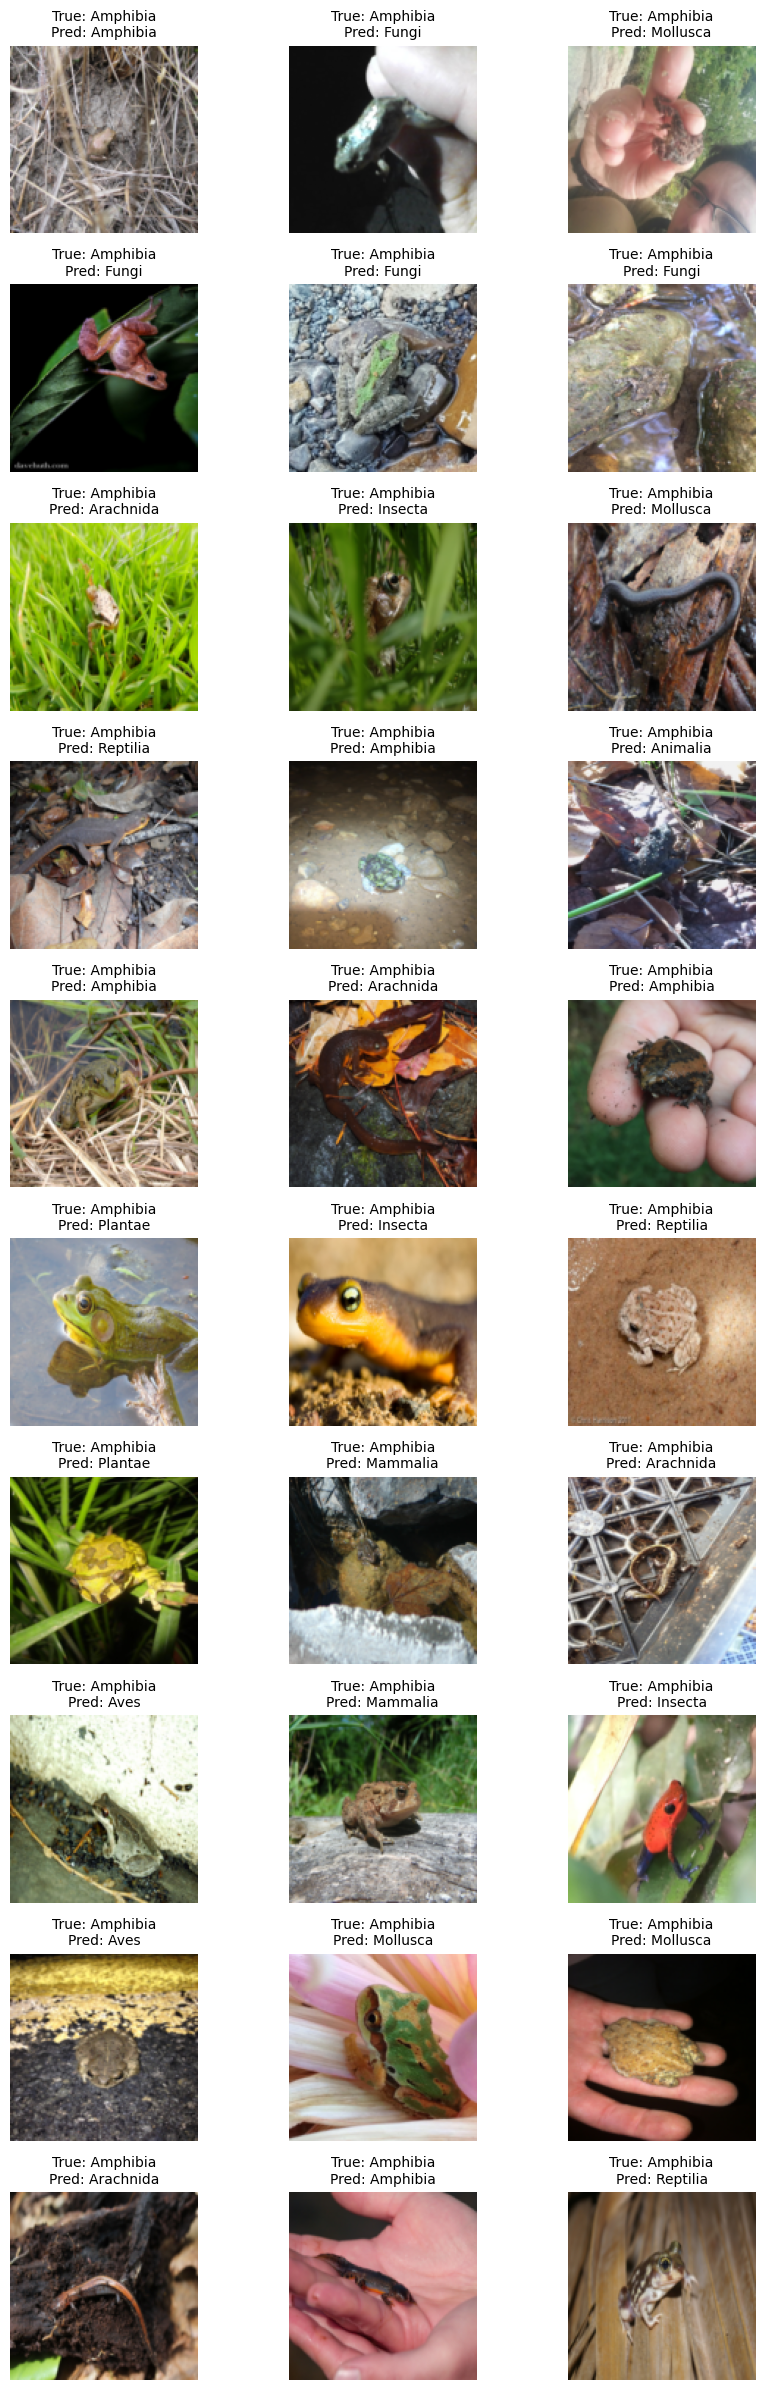

In [22]:
# Cell 2: Load saved model, evaluate on test set, and show 10×3 prediction grid

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# ——— Globals you should have defined earlier ———
# dataset_mean, dataset_std, IMG_SIZE, NUM_CLASSES, SmallCNN,
# filt_list, kernel_size, activation, use_batchnorm, dropout_p, hidden_units, DATA_DIR

# 1) Build the test DataLoader
normalize = transforms.Normalize(mean=dataset_mean, std=dataset_std)
test_tf   = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    normalize,
])
# Make sure this points to your **test** split, not validation!
TEST_DIR  = DATA_DIR.replace("train", "val")
test_ds   = datasets.ImageFolder(TEST_DIR, transform=test_tf)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

# 2) Rebuild model and load weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN(
    in_ch=3,
    filters_per_layer=filt_list,
    kernel_size=kernel_size,
    activation=activation,
    use_batchnorm=use_batchnorm,
    dropout_p=dropout_p,
    dense_units=hidden_units,
    num_classes=NUM_CLASSES,
    input_size=IMG_SIZE
).to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

# 3) Compute overall test accuracy
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds  = model(xb).argmax(dim=1)
        correct+= (preds == yb).sum().item()
        total  += yb.size(0)
print(f"🎯 Test Accuracy: {100*correct/total:.2f}%")

# 4) Display a 10×3 grid of predictions
class_names = test_ds.classes
fig, axes = plt.subplots(10, 3, figsize=(9, 24))

for i, ax in enumerate(axes.flatten()):
    # get the i‑th sample as a tensor
    img_tensor, true_label = test_ds[i]

    # 4a) Run inference on the tensor
    with torch.no_grad():
        pred_label = model(img_tensor.unsqueeze(0).to(device)).argmax(1).item()

    # 4b) Unnormalize and convert to numpy for plotting
    disp = img_tensor.cpu() * torch.tensor(dataset_std).view(3,1,1) \
           + torch.tensor(dataset_mean).view(3,1,1)
    disp = disp.permute(1,2,0).numpy().clip(0,1)

    ax.imshow(disp)
    ax.set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
                 fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()
